# Deep Learning: Ex.9 - YOLO

Submitted by: [... **Ran Ben Melech** ...]


In [91]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt


# YAD2K: Yet Another Darknet 2 Keras
# https://github.com/allanzelener/YAD2K 
from yad2k.models.keras_yolo import * 


from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes

***
### 1. Loading the model

- loading the YOLO model (tiny yolo_v2) + its weights (~45MB)
- importing the 80 classes names from the text file
- importing the 5 anchors from the text file

note: you can check the code of the helper functions `read_classes` and `read_anchors` in the `yolo_utils` directory.

In [92]:
yolo_model = load_model('model_data/yolo_v2_tiny.h5') 

class_names = read_classes('model_data/coco_classes.txt') 

anchors = read_anchors('model_data/yolo_v2_anchors.txt')

# (ignore the "No training configuration found" warning..)

- print the model's summary, the anchors and the class names.

In [93]:
yolo_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 416, 416, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 416, 416, 16)      432       
_________________________________________________________________
batch_normalization_1 (Batch (None, 416, 416, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 416, 416, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 208, 208, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 208, 208, 32)      4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 208, 208, 32)      128 

In [94]:
print ("class names:\n",class_names)

class names:
 ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [95]:
print ("anchors:\n",anchors)

anchors:
 [[0.57273  0.677385]
 [1.87446  2.06253 ]
 [3.33843  5.47434 ]
 [7.88282  3.52778 ]
 [9.77052  9.16828 ]]


***
### 2. Preprocess an image

We use the helper function `preprocess_image` to:
- load an image
- scale its size to (416,416) 
- scale the values from 0-255 to 0.0-1.0
- add an extra 'dummy' dimension ("batch" of 1 image): (416,416,3) -> (1,416,416,3)

image size (H,W) = (424.0, 640.0)
image_data.shape = (1, 416, 416, 3)


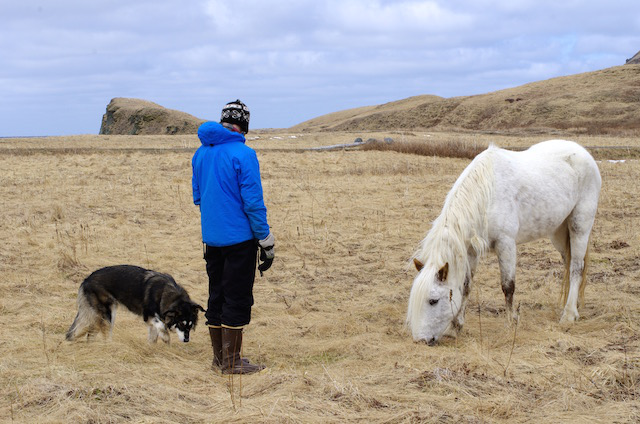

In [96]:
image, image_data, image_size = preprocess_image('test_images/person.jpg', model_image_size = (416, 416))

print('image size (H,W) =',image_size)
print('image_data.shape =',image_data.shape)
image


***
### 2. Pass the image through the YOLO model

- The input image goes through a CNN, resulting in a (13,13,5,85) dimensional output. 
- After flattening the last two dimensions (5x85), the output is a volume of shape (13, 13, 425):

In [97]:
yolo_output = yolo_model(image_data)
yolo_output.shape

TensorShape([1, 13, 13, 425])

the `yolo_head` function convert final layer features (`yolo_output`) to bounding box parameters:

- box_conf : Probability estimate for whether each box contains any object.
- box_xy : x, y box predictions adjusted by spatial location in conv layer.
- box_wh : w, h box predictions adjusted by anchors and conv spatial resolution.
- box_class_pred : Probability distribution estimate for each box over class labels.

In [98]:

head = yolo_head(yolo_output, anchors, len(class_names)) #  from YAD2K library

box_conf, box_xy, box_wh, box_class_pred = head # unpack the output


print (box_conf.shape)

(1, 13, 13, 5, 1)


- the results are of Tensorflow array type, use `.numpy()` to convert them to NumPy arrays.
- print the shape of each one

In [99]:
box_conf=box_conf[0].numpy()
box_xy=box_xy[0].numpy()
box_wh=box_wh[0].numpy()
box_class_pred=box_class_pred[0].numpy()
print("box conf shape:",box_conf.shape)
print("box_xy shape:",box_xy.shape)
print("box_wh shape:",box_wh.shape)
print("box_class_pred shape:",box_class_pred.shape)

box conf shape: (13, 13, 5, 1)
box_xy shape: (13, 13, 5, 2)
box_wh shape: (13, 13, 5, 2)
box_class_pred shape: (13, 13, 5, 80)


- lets visulalize, the `box_conf` values for the 3rd anchor (out of the 5):

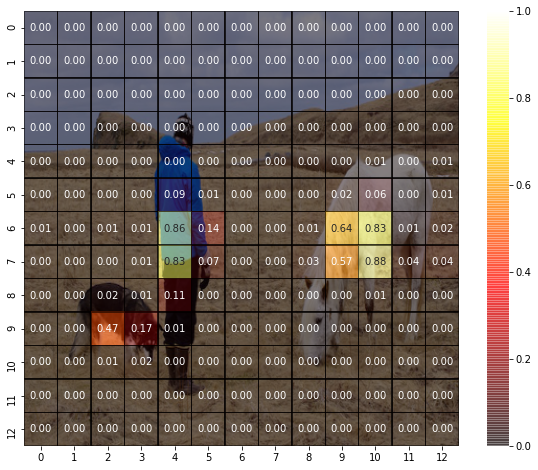

In [100]:
from seaborn import heatmap 

plt.figure(figsize=(10,8))
plt.imshow(image_data[0],extent=(0,13,13,0))
heatmap(box_conf[:,:,2,0],annot=True,cmap='hot',fmt='.2f',alpha=0.5,vmin=0,vmax=1,linecolor='black',linewidth=0.5)


- visualize the `box_conf` values for the rest of the anchors (use subplots):

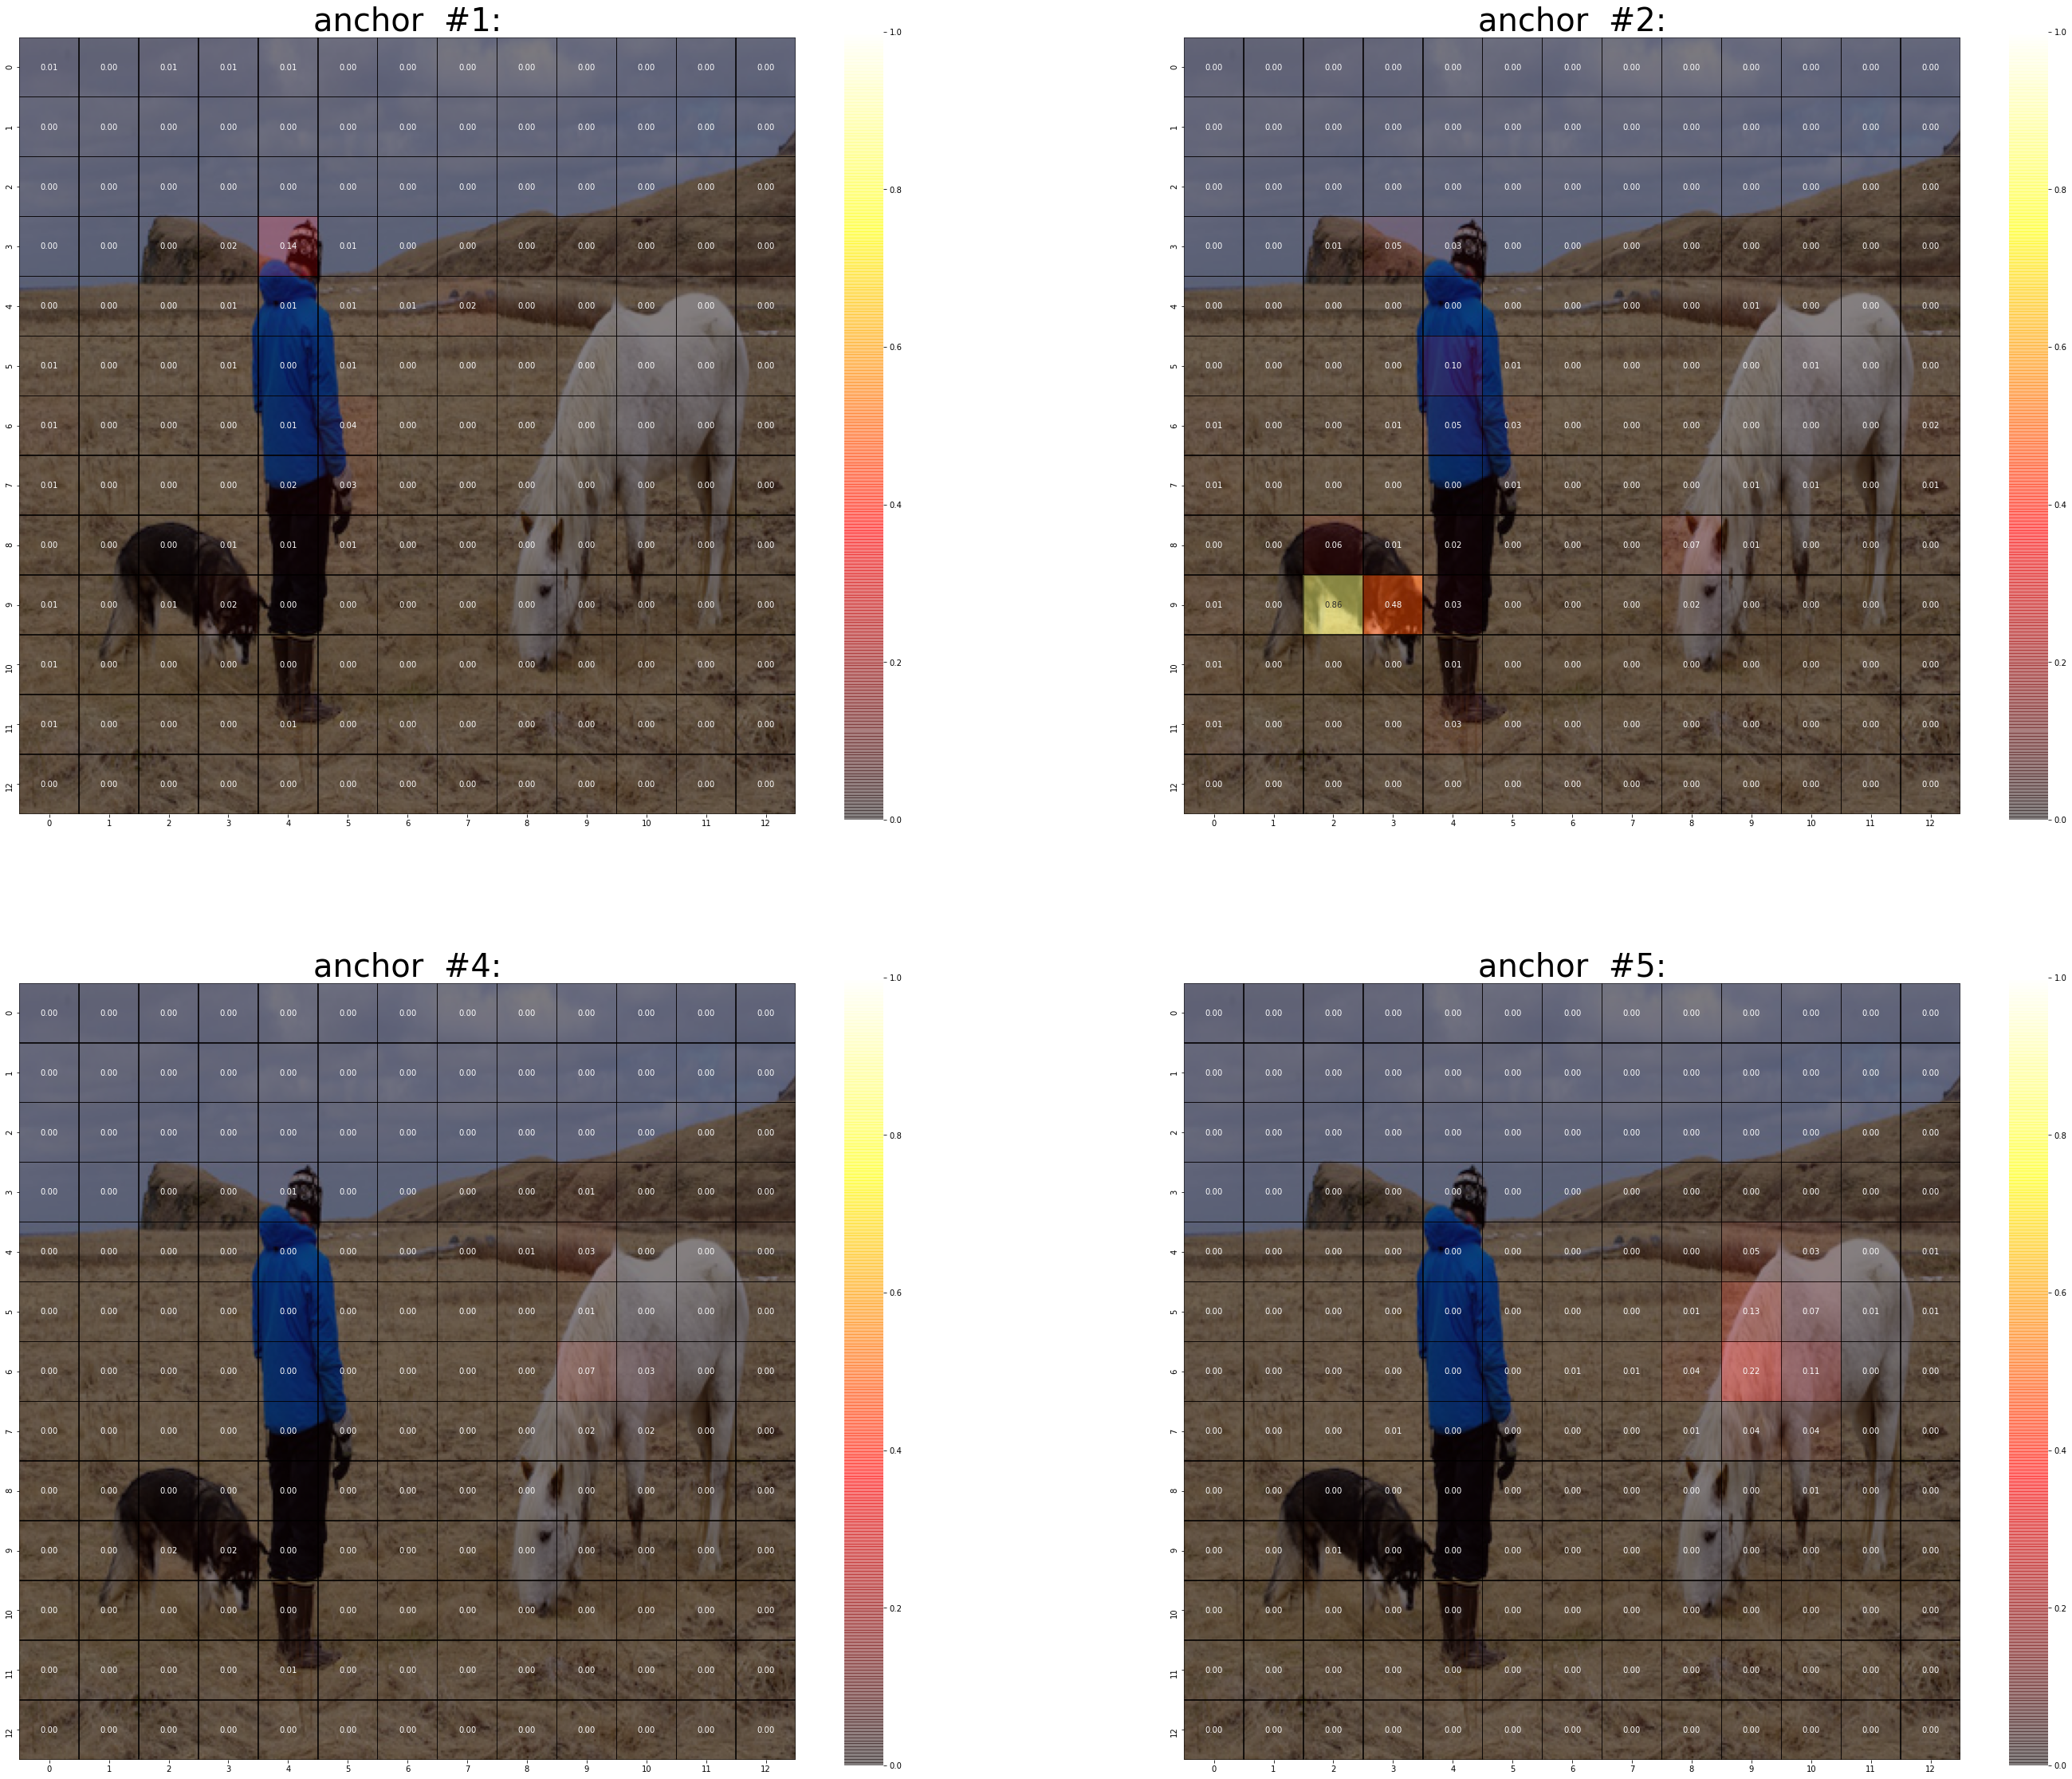

In [101]:
fig,axes = plt.subplots(2, 2,figsize=(48,40))
counter=0
for i in range(2):
    for j in range(2):
        if counter==2:
            counter+=1
        
        heatmap(box_conf[:,:,counter,0], annot=True, cmap='hot',fmt='.2f',alpha=0.5,vmin=0,vmax=1,linecolor='black',linewidth=0.5,ax = axes[i,j])
        axes[i,j].imshow(image_data[0],extent=(0,13,13,0))
        title= "anchor  #{}:".format(counter+1)
        axes[i,j].set_title(title,fontsize = 40)
        counter+=1

- use `.max` to visualize the maximum value of `box_conv` in each cell over the 5 anchors:

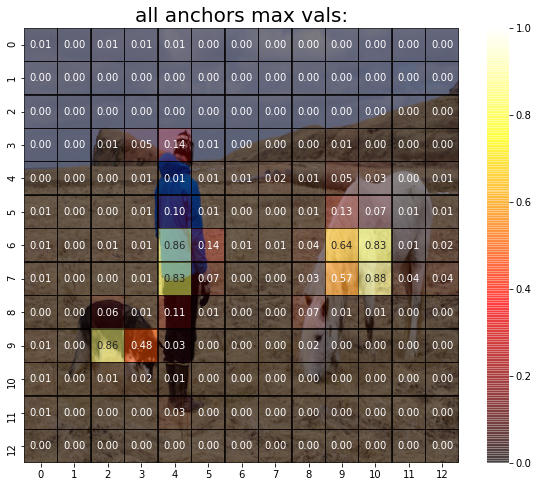

In [102]:
conf_max=np.ndarray(shape=(13,13,1,1))

for i in range(13):
    for j in range(13):
                conf_max[i,j,0,0]=box_conf[i,j,:,:].max()
plt.figure(figsize=(10,8))
plt.imshow(image_data[0],extent=(0,13,13,0))
plt.title("all anchors max vals:",fontsize=20)
heatmap(conf_max[:,:,0,0],annot=True,cmap='hot',fmt='.2f',alpha=0.5,vmin=0,vmax=1,linecolor='black',linewidth=0.5)
           

- Compute `box_scores` by doing the elementwise product `box_conf` and `box_class_pred`:
- print the shape of the result

In [138]:

box_scores=box_conf*box_class_pred
print (box_scores.shape)
            

(13, 13, 5, 80)


We have 13x13x5 "boxes" (13x13 grid cells, and in each one 5 "boxes" - one for each anchor)

For each of these boxes (13x13x5): 
- find the index of the class with the highest `box_score` 
- find the corresponding `box_score` 

(hint: no need for any loops here..)

In [144]:
c=np.array(80)
c=np.max(box_scores[:,:,:,:])
print(c)

0.8571146


- find all the boxes with a minimum score of `threshold=0.6`
- how many boxes did you find? 
- for each one of them, print their: grid cell index (i,j), anchor index (0-4), score and class name.

(hint: `np.where()` might come handy..)

***
### 3. Visualize the results

- We can use the methods in `yolo_utils` to visualize the results.

- Compare it with the boxes you have found.

horse 0.63 (408, 115) (603, 329)
dog 0.66 (66, 258) (203, 349)
horse 0.75 (420, 133) (597, 335)
person 0.83 (188, 109) (277, 368)
person 0.86 (184, 100) (277, 337)


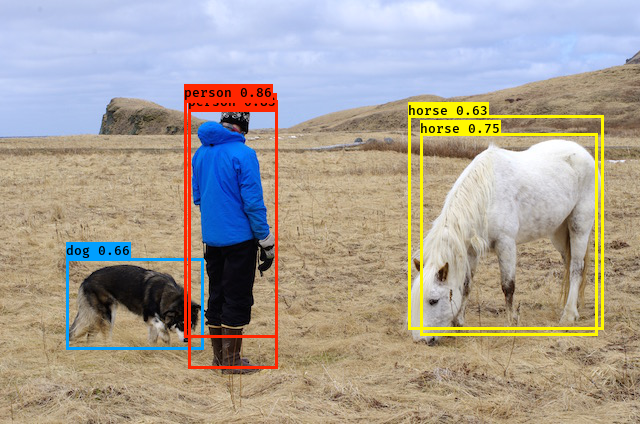

In [15]:
boxes, scores, classes= yolo_eval(head, image_size,max_boxes=20, score_threshold=0.6, iou_threshold=1.0)

colors = generate_colors(class_names)

draw_boxes(image, scores, boxes, classes, class_names, colors)

image

- play with `score_threshold` and `iou_threshold` parameters, to get a better results:

dog 0.66 (66, 258) (203, 349)
horse 0.75 (420, 133) (597, 335)
person 0.86 (184, 100) (277, 337)


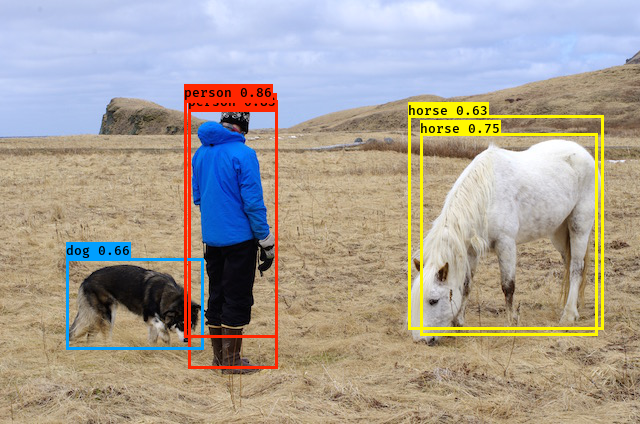

In [20]:
boxes, scores, classes= yolo_eval(head, image_size,max_boxes=20, score_threshold=0.65, iou_threshold=0.7)

colors = generate_colors(class_names)

draw_boxes(image, scores, boxes, classes, class_names, colors)

image

- pick 2-3 images (either from the `test_images` folder, or better yet - pick some yourself), run the YOLO network and show the final resutls.

motorbike 0.44 (64, 78) (100, 120)
dog 0.44 (128, 212) (389, 531)
car 0.62 (455, 85) (669, 166)
bicycle 0.67 (59, 157) (588, 423)
bicycle 0.85 (45, 93) (596, 482)


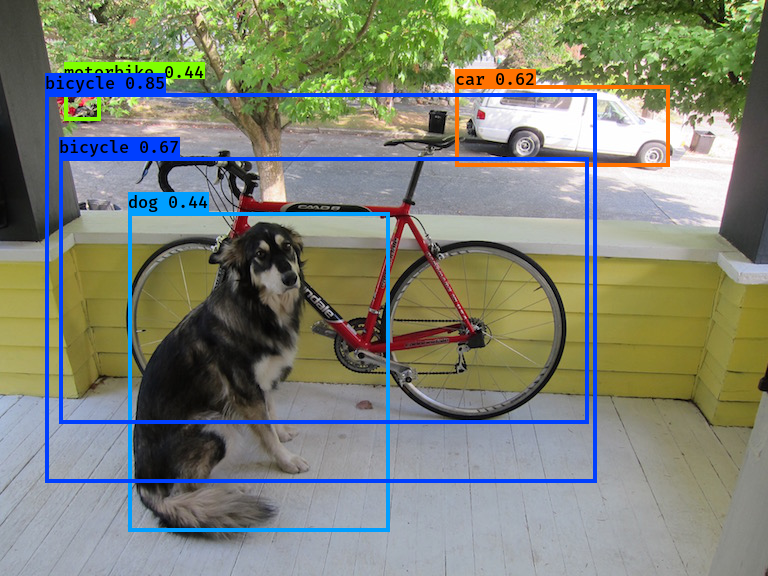

In [40]:
image1, image_data1, image_size = preprocess_image('test_images/dog.jpg', model_image_size = (416, 416))

yolo_output = yolo_model(image_data1)

head = yolo_head(yolo_output, anchors, len(class_names)) #  from YAD2K library

box_conf, box_xy, box_wh, box_class_pred = head # unpack the output

boxes1, scores1, classes1= yolo_eval(head, image_size,max_boxes=20, score_threshold=0.43, iou_threshold=0.7)

colors = generate_colors(class_names)

draw_boxes(image1, scores1, boxes1, classes1, class_names, colors)

image1

***
## Good Luck!

horse 0.46 (224, 187) (437, 374)
horse 0.58 (7, 183) (171, 255)
horse 0.87 (421, 208) (589, 352)
horse 0.87 (9, 187) (292, 400)


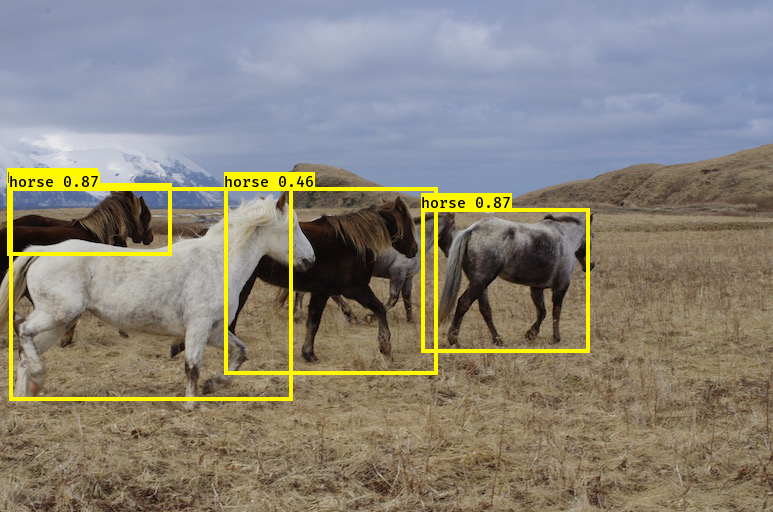

In [38]:
image1, image_data1, image_size = preprocess_image('test_images/horses.jpg', model_image_size = (416, 416))

yolo_output = yolo_model(image_data1)

head = yolo_head(yolo_output, anchors, len(class_names)) #  from YAD2K library

box_conf, box_xy, box_wh, box_class_pred = head # unpack the output

boxes1, scores1, classes1= yolo_eval(head, image_size,max_boxes=20, score_threshold=0.45, iou_threshold=0.4)

colors = generate_colors(class_names)

draw_boxes(image1, scores1, boxes1, classes1, class_names, colors)

image1